In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import pandas as pd

import esm

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
FASTA_PATH = "../data/allterp.faa" # Path to fasta
FASTA_CLASSES_PATH = "../data/terp.faa"
NEW_FASTA_PATH = "../data/neighbours_extended_terp.faa"
EMB_PATH = "../data/allterp_emb_esm2_33" # Path to directory of embeddings for fasta
EMB_CLASSES_PATH = "../data/terp_emb_esm2_33" # Path to directory of embeddings for fasta
EMB_LAYER = 33

Our embeddings are stored with the file name from fasta header: {acc_num}_{category}.pt

In [3]:
ys = []
Xs = []
ys_tc = []
Xs_tc = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    category = header.split('_')[-1]
    ys.append(category)
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
    if 'tc' in category:
        ys_tc.append(header)
        fn = f'{EMB_PATH}/{header}.pt'
        embs = torch.load(fn)
        Xs_tc.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
Xs_tc = torch.stack(Xs_tc, dim=0).numpy()
print(len(ys))
print(Xs.shape)
print(len(ys_tc))
print(Xs_tc.shape)

945
(945, 1280)
416
(416, 1280)


### Reading only categorised sequences

In [4]:
ys_classes = []
Xs_classes = []

for header, _seq in esm.data.read_fasta(FASTA_CLASSES_PATH):
    category = header.split('_')[-1]
    ys_classes.append(category)
    fn = f'{EMB_CLASSES_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs_classes.append(embs['mean_representations'][EMB_LAYER])
Xs_classes = torch.stack(Xs_classes, dim=0).numpy()

print(len(ys_classes))
print(Xs_classes.shape)

534
(534, 1280)


In [5]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((756, 1280), (189, 1280), 756, 189)

### PCA

In [6]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

### Visualise Embeddings

In [7]:
categories_dict = dict.fromkeys(ys)
num = 0
for key in categories_dict:
    categories_dict[key] = num
    num += 1
    
categories_dict_no_tc = dict.fromkeys(ys_classes)
num = 1
for key in categories_dict_no_tc:
    categories_dict_no_tc[key] = num
    num += 1

    
ys_train_numbers_for_colours = []
for i in range(0, len(ys_train)):
    ys_train_numbers_for_colours.append(categories_dict[ys_train[i]])
    
ys_classes_numbers = []
for i in range(0, len(ys_classes)):
    ys_classes_numbers.append(categories_dict[ys_classes[i]])


In [8]:
inv_categories = {v: k for k, v in categories_dict.items()}
inv_categories_no_tc = {v: k for k, v in categories_dict_no_tc.items()}

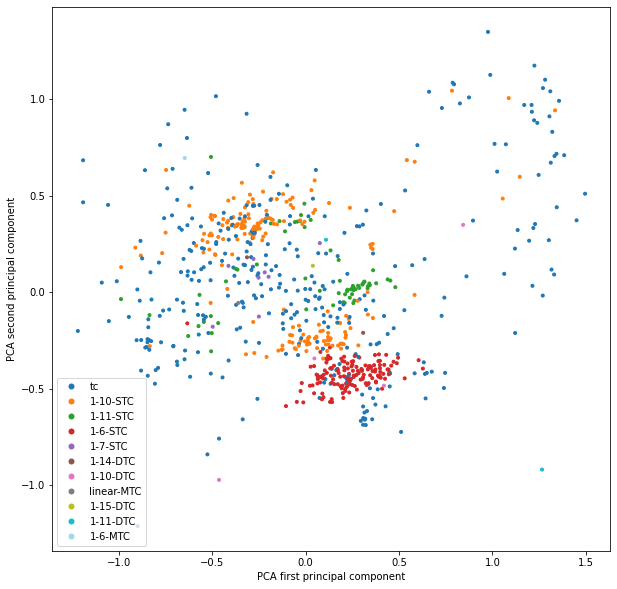

In [9]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train_numbers_for_colours, marker='.', cmap='tab20')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
ax.legend(*sc.legend_elements())

lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec="none",
                        label=inv_categories[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(ys_train_numbers_for_colours)]

ax.legend(handles=handles)

### Dataframes for one hot encoding

In [10]:
classes_for_one_hot = list(zip(ys_classes_numbers, ys_classes))
one_hot_array = OneHotEncoder().fit_transform(list(zip(list(categories_dict_no_tc.values()), list(categories_dict_no_tc.keys())))).toarray()
y = OneHotEncoder().fit_transform(classes_for_one_hot).toarray()

### Initialize grids for different regression techniques - doesn't work from here on

In [11]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    

In [12]:
# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', KNeighborsRegressor())
    )
)


result_list = []
grid_list = []
print(KNeighborsRegressor)
grid = GridSearchCV(
    estimator = pipe,
    param_grid = knn_grid,
    scoring = 'r2',
    verbose = 1,
    n_jobs = -1 # use all available cores

)
grid.fit(Xs_classes, y)
result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
grid_list.append(grid)

print(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV(estimator=Pipeline(steps=(('pca', PCA(n_components=60)),
                                       ('model', KNeighborsRegressor()))),
             n_jobs=-1,
             param_grid=[{'model': [KNeighborsRegressor(algorithm='ball_tree',
                                                        leaf_size=15, p=1,
                                                        weights='distance')],
                          'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__leaf_size': [15, 30],
                          'model__n_neighbors': [5, 10], 'model__p': [1, 2],
                          'model__weights': ['uniform', 'distance']}],
             scoring='r2', verbose=1)


### K Nearest Neighbors


In [13]:
result_list[0].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.073768,0.018197,0.006449,0.001615,"KNeighborsRegressor(algorithm='ball_tree', lea...",kd_tree,15,10,2,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.787604,0.582001,0.702233,0.909505,0.313611,0.658991,0.203166,1
43,0.058992,0.003708,0.005267,0.000330,"KNeighborsRegressor(algorithm='ball_tree', lea...",brute,30,5,2,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.787604,0.582001,0.702233,0.909505,0.313611,0.658991,0.203166,1
40,0.060018,0.002716,0.005304,0.000288,"KNeighborsRegressor(algorithm='ball_tree', lea...",brute,30,5,1,uniform,{'model': KNeighborsRegressor(algorithm='ball_...,0.787604,0.582001,0.702233,0.909505,0.313611,0.658991,0.203166,1
39,0.070374,0.012175,0.006004,0.001244,"KNeighborsRegressor(algorithm='ball_tree', lea...",brute,15,10,2,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.787604,0.582001,0.702233,0.909505,0.313611,0.658991,0.203166,1
37,0.055880,0.001314,0.006267,0.001016,"KNeighborsRegressor(algorithm='ball_tree', lea...",brute,15,10,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.787604,0.582001,0.702233,0.909505,0.313611,0.658991,0.203166,1


### Evaluation

In [14]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')

KNeighborsRegressor()

SpearmanrResult(correlation=array([[ 1.        , -0.20745167,  0.18995049,  0.10063534,  0.18977893,
         0.02667039,  0.07644891,  0.13312339,         nan,  0.07644891,
         0.15412594,  0.07644891, -0.20745167,  0.07644891,  0.18995049,
         0.02667039,         nan,  0.15412594,  0.10063534,  0.18977893,
         0.13312339],
       [-0.20745167,  1.        , -0.38646767, -0.70797122, -0.06930279,
        -0.01123002,  0.00719981, -0.06519393,         nan, -0.00791979,
        -0.00658179,  0.00719981,  1.        , -0.00791979, -0.38646767,
        -0.01123002,         nan, -0.00658179, -0.70797122, -0.06930279,
        -0.06519393],
       [ 0.18995049, -0.38646767,  1.        , -0.24924926,  0.07941079,
        -0.05876897, -0.04144586,  0.19603963,         nan, -0.04144586,
        -0.08355752, -0.04144586, -0.38646767, -0.04144586,  1.        ,
        -0.05876897,         nan, -0.08355752, -0.24924926,  0.07941079,
         0.19603963],
       

/home/klara/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/klara/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [15]:
result_list[0].sort_values('rank_test_score')[:1].values

array([[0.07376832962036133, 0.018196778447691818, 0.006449460983276367,
        0.0016151238849396437,
        KNeighborsRegressor(algorithm='ball_tree', leaf_size=15, p=1,
                            weights='distance')                      ,
        'kd_tree', 15, 10, 2, 'distance',
        {'model': KNeighborsRegressor(algorithm='ball_tree', leaf_size=15, p=1,
                            weights='distance'), 'model__algorithm': 'kd_tree', 'model__leaf_size': 15, 'model__n_neighbors': 10, 'model__p': 2, 'model__weights': 'distance'},
        0.7876035449737586, 0.5820011690618838, 0.7022325002742366,
        0.9095048707214101, 0.3136111311080122, 0.6589906432278603,
        0.2031663857027078, 1]], dtype=object)

In [16]:
clustered = grid.predict(Xs_tc)

### Searching for matches between predictions and one_hot_encoding

In [17]:
matches = []

i = 0
for point in clustered.tolist()[1:]:
    if point in one_hot_array.tolist():
        matches.append([ys_tc[i], one_hot_array.tolist().index(point) + 1])
    i += 1
len(matches)

228

### Write all classified sequences to a new file

In [18]:
matches_dict = dict(matches)

In [19]:
outfile = open(NEW_FASTA_PATH, 'w')

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    if 'tc' in header:
        if header in matches_dict:
            new_header = header + '_' + inv_categories_no_tc[matches_dict[header]]
            outfile.write(new_header + '\n')
            outfile.write(_seq)
            outfile.write('\n')
    else:
        outfile.write(header + '\n')
        outfile.write(_seq)
        outfile.write('\n')
        
        
outfile.close()
print('New file ready')

New file ready
